## Реализация алгоритма A2C для среды MountainCarContinuous c непрерывным действием

In [139]:
#assert python version >=3,5
import sys
assert sys.version_info >= (3,5)

import gymnasium as gym
assert gym.__version__ >= '0.27.1'


from collections import deque
import copy
import math
import numpy as np
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import pdb
import random
import sklearn
import sklearn.preprocessing
from tqdm import tqdm

try:
    import Box2D
except ImportError:
    warnings.warn('Failed to import', ImportWarning)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [144]:
class Actor:
    '''
    Базовый класс для Эктора
    '''
    def __init__(self, env:gym.Env):
        self.env = env
        self.a_low = torch.tensor(env.action_space.low, device=device)
        self.a_high = torch.tensor(env.action_space.high, device=device)

    def pi(self, s_t:torch.Tensor):
        raise NotImplementedError

    def parameters(self):
        raise NotImplementedError

        
    def act(self, s_t:torch.Tensor) -> np.ndarray:
        with torch.inference_mode():
            a_t = self.pi(s_t).sample()
            a_t = torch.clamp(a_t, self.a_low, self.a_high)
            return a_t.cpu().numpy()
    
    def learn(self, states:torch.Tensor, actions:torch.Tensor, advantages:torch.Tensor) -> float:
        '''
        Выучиваем градиенты логарифмов распределения политики
        '''
        log_prob = self.pi(states).log_prob(actions)
        loss = torch.mean(-log_prob*advantages)
        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(self.parameters(), 100.)
        self.opt.step()
        return loss

In [140]:
class ActorNet(nn.Module):
    '''
    Архитектура сети Эктора
    '''

    def __init__(self, input_dim:int, out_dim:int):
        super(ActorNet, self).__init__()
        assert(input_dim >= 1)
        assert(out_dim >= 1)
        self.linear1 = torch.nn.Linear(input_dim, 512).double()
        self.linear2 = torch.nn.Linear(512, 128).double()
        self.linear3 = torch.nn.Linear(128, out_dim).double()
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)
        nn.init.xavier_normal_(self.linear3.weight)
        

    def forward(self, x:torch.Tensor) -> np.ndarray:
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu1 = self.linear3(x)
        return mu1

    
class DiagonalGaussianActor(Actor):
    '''
    Агент политики, реализует непрерывные действия
    '''
    
    def __init__(self, env:gym.Env, lr:float=1e-4, learn_sigma:bool=False):
        super(DiagonalGaussianActor, self).__init__(env)
        
        self.learn_sigma = learn_sigma
        N = env.observation_space.shape[0]
        M = env.action_space.shape[0]
        
        self.mu = ActorNet(N,M).to(device)

        if learn_sigma:
            self.log_sigma = torch.ones(M, dtype=torch.double, requires_grad=True, device=device)
            self.opt = torch.optim.AdamW(list(self.mu.parameters()) + [self.log_sigma], lr=lr, amsgrad=True)
        else:
            self.opt = torch.optim.AdamW(self.mu.parameters(), lr=lr, amsgrad=True)

            
    def pi(self, s_t):
        '''
        Возврат распределения политики
        '''
        s_t = torch.as_tensor(s_t, device=device).double()
        mu = self.mu(s_t)
        if self.learn_sigma:
            log_sigma = self.log_sigma
            sigma = torch.exp(log_sigma)
            pi = torch.distributions.MultivariateNormal(mu, torch.diag(sigma))
        else:
            sigma = torch.ones_like(mu, dtype=torch.double, device=device) / 2.0
            pi = torch.distributions.Normal(mu, sigma)
        return pi
    

    def parameters(self):
        if self.learn_sigma:
            return list(self.mu.parameters()) + [self.log_sigma]
        else:
            return self.mu.parameters()

In [145]:
class CriticNet(nn.Module):
    '''
    Архитектура сети для Критика
    '''

    def __init__(self, input_dim:int):
        super(CriticNet, self).__init__()
        assert(input_dim >= 1)
        self.linear1 = torch.nn.Linear(input_dim, 512).double()
        self.linear2 = torch.nn.Linear(512, 128).double()
        self.linear3 = torch.nn.Linear(128, 1).double()
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)
        nn.init.xavier_normal_(self.linear3.weight)
        

    def forward(self, x:torch.Tensor) -> np.array:
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)


class Critic:
    '''
    Класс Критик, реализует предсказание StateValues для переданных состояний
    '''
    def __init__(self, env:gym.Env, lr:float=1e-4):
        N = env.observation_space.shape[0]
        self.V = CriticNet(N).double().to(device)
        self.opt = torch.optim.AdamW(self.V.parameters(), lr=lr, amsgrad=True)
        
    def predict(self, s_t:torch.Tensor) -> np.ndarray:
        s_t = torch.tensor(s_t, dtype=torch.double, device=device)
        return self.V(s_t)

    def learn(self, V_pred:torch.Tensor, returns:torch.Tensor) -> float:
        loss = torch.mean((V_pred - returns)**2)
        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(self.V.parameters(), 100.)
        self.opt.step()
        return loss

In [146]:
def fit_scaler(env:gym.Env) -> sklearn.preprocessing.StandardScaler:
    '''
    Обучаем скейлер для состояний игры
    '''
    state_space_samples = np.array(
        [env.observation_space.sample() for x in range(10000)])
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(state_space_samples)
    return scaler

In [147]:
def A2C(env:gym.Env, agent:Actor, critic:Critic, scaler:sklearn.preprocessing.StandardScaler, gamma:float=0.99, epochs:int=256, train_V_iters:int=200):  
    '''
    Функция реализует алгоритм A2C
    env = среда для исследования
    agent - сеть Эктора для прогноза политики
    critic - сеть Криттика для прогноза advantages состояний
    sclaer - просто скейлер состояний среды (с ним сходится значительно лучше)
    gamma - коэффициент дисконта
    epochs - сколько эпизодов разыгрываем
    train_V_iters - число эпох обучения сети Критик 
    '''
    reward_records = []
    states = []
    actions = []
    rewards = []

    #цикл по эпизодам
    for epoch in range(epochs):
        done = False
        states = []
        actions = []
        rewards = []
        s, _ = env.reset()
        #собираем траекторию
        while not done:
            s_t = scaler.transform([s])[0]
            states.append(s_t)
            a = agent.act([s_t])[0]
            s_t_next, r, term, trunc, _ = env.step(a)
            done = term or trunc
            actions.append(a)
            rewards.append(r)
            s = s_t_next
        
        # формируем массив полной награды для каждого состояния
        cum_rewards = np.zeros_like(rewards)
        reward_len = len(rewards)
        for j in reversed(range(reward_len)):
            cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

        cum_rewards = torch.tensor(cum_rewards, dtype=torch.double, device=device).unsqueeze(dim=1)
        # Оптимизируем value loss (Critic)
        for _ in range(train_V_iters):
            V_pred = critic.predict(states)
            critic.learn(V_pred, cum_rewards)
        # считаем advantage функцию
        advantages = cum_rewards - V_pred.detach()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)
        actions = torch.tensor(actions, dtype=torch.double).to(device)    
        #обучение Эктора
        pi_loss = agent.learn(states, actions, advantages)        
        
        reward_records.append(sum(rewards))
        print(f'{epoch}/{epochs}:{np.mean(reward_records[-100:])}\r', end='')

    return reward_records

In [126]:
actor = DiagonalGaussianActor(env)
critic = Critic(env)
scaler = fit_scaler(env)
rewards = A2C(env, actor, critic, scaler,epochs=500)

### Визуализация наград и розыгрыш игры

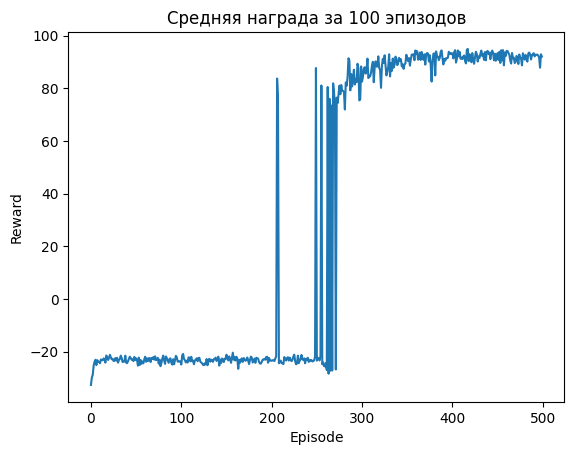

In [149]:
plt.plot(rewards)
plt.title('Средняя награда за 100 эпизодов')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

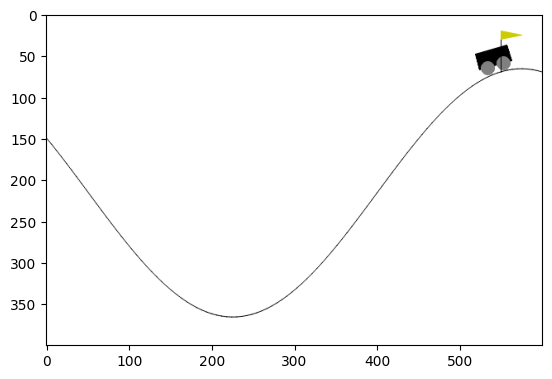

In [150]:
state, info = env.reset(seed=1233)
#розыгрыш игры
for i in range(env.spec.max_episode_steps):
    if i % 2 == 0:
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)
    action = actor.act(scaler.transform([state])[0])
    state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break